In [2]:
import os
import email
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
from os import path
import re
import csv
import tensorflow as tf
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.translate.bleu_score import sentence_bleu
from sklearn.utils import shuffle
import nltk
import random
from nltk import bigrams, trigrams
from collections import Counter, defaultdict
from multiprocessing import  Pool
from nltk.corpus import reuters


In [3]:
df = pd.read_csv("emails.csv")
df = df.sample(frac=0.35, random_state=42)
df.reset_index(inplace = True, drop = True)

In [4]:
df.head()

,file,message
0,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...
1,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...
2,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...
3,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...
4,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...


In [5]:
df.shape

(181090, 2)

In [6]:
df['message'][0]

'Message-ID: <21013688.1075844564560.JavaMail.evans@thyme>\nDate: Tue, 29 Aug 2000 01:26:00 -0700 (PDT)\nFrom: sara.shackleton@enron.com\nTo: william.bradford@enron.com\nSubject: Re: Credit Derivatives\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Sara Shackleton\nX-To: William S Bradford\nX-cc: \nX-bcc: \nX-Folder: \\Sara_Shackleton_Dec2000_June2001_1\\Notes Folders\\Sent\nX-Origin: SHACKLETON-S\nX-FileName: sshackle.nsf\n\nBill:  Thanks for the info.   I also spoke with Jeff about how \nEnronCredit.com Ltd. was going to work since Dennis O\'Connell (London lawyer) \nis responsible for that group.  Maybe you will be able to clarify which of \nJeff\'s "positions" will be hedges and which will be backed to EnronCredit.  \nMaybe Rod will be handling most of Jeff\'s credit.  I\'d appreciate an update.  \nSara\n\n\n\n\tWilliam S Bradford\n\t08/29/2000 07:24 AM\n\t\t\n\t\t To: Sara Shackleton/HOU/ECT@ECT\n\t\t cc: Mark Taylor/HOU/EC

In [7]:
def body(messages):
    column = []
    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get_payload())
    return column

df['content'] = body(df['message'])

In [8]:
df.head()


,file,message,content
0,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...,Bill: Thanks for the info. I also spoke wit...
1,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...,"Aimee,\nPlease check meter #1591 Lamay gas lif..."
2,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...,GCCA Crawfish and rip-off raffle & over-priced...
3,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...,"<<Keoni.zip>> Chris, per your request here ar..."
4,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...,I'm trying to change the Receipt Meter on deal...


In [9]:
df.content = df.content.str.replace("\n","")
df.content = df.content.apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
df.content = df.content.str.lower()
df.content = df.content.str.strip()

In [10]:
df.head()

,file,message,content
0,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...,bill thanks for the info i also spoke with jef...
1,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...,aimee please check meter 1591 lamay gas lift i...
2,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...,gcca crawfish and rip off raffle over priced p...
3,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...,keoni zip chris per your request here are the ...
4,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...,i m trying to change the receipt meter on deal...


In [11]:
df['body_list'] = df.content.apply(lambda x: x.split())

In [12]:
df.head()

,file,message,content,body_list
0,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...,bill thanks for the info i also spoke with jef...,"[bill, thanks, for, the, info, i, also, spoke,..."
1,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...,aimee please check meter 1591 lamay gas lift i...,"[aimee, please, check, meter, 1591, lamay, gas..."
2,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...,gcca crawfish and rip off raffle over priced p...,"[gcca, crawfish, and, rip, off, raffle, over, ..."
3,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...,keoni zip chris per your request here are the ...,"[keoni, zip, chris, per, your, request, here, ..."
4,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...,i m trying to change the receipt meter on deal...,"[i, m, trying, to, change, the, receipt, meter..."


Text(0, 0.5, 'Frequency')

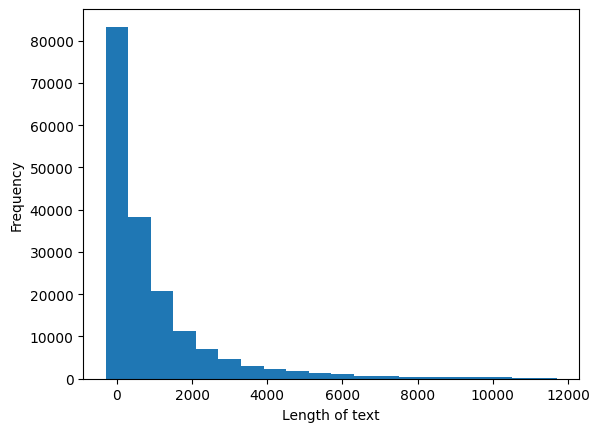

In [13]:
  # EDA for text length
x = list(df['content'].apply(lambda x:len(x)))
plt.hist(x,range=[1,12000],bins = 20,align ='left')
plt.rcParams["figure.figsize"] = (10,4)
plt.xlabel("Length of text")
plt.ylabel("Frequency")

In [14]:
if __name__ == "__main__":
  for i in range(0,110,10):
    print("{}th- percentile of len(text) is {}".format(i,np.percentile(x, i)))
    print("="*40)
  x =None
  del(x)
  gc.collect()

0th- percentile of len(text) is 0.0
10th- percentile of len(text) is 100.0
20th- percentile of len(text) is 199.0
30th- percentile of len(text) is 325.0
40th- percentile of len(text) is 483.0
50th- percentile of len(text) is 687.0
60th- percentile of len(text) is 956.0
70th- percentile of len(text) is 1314.0
80th- percentile of len(text) is 1909.0
90th- percentile of len(text) is 3282.0
100th- percentile of len(text) is 1594315.0


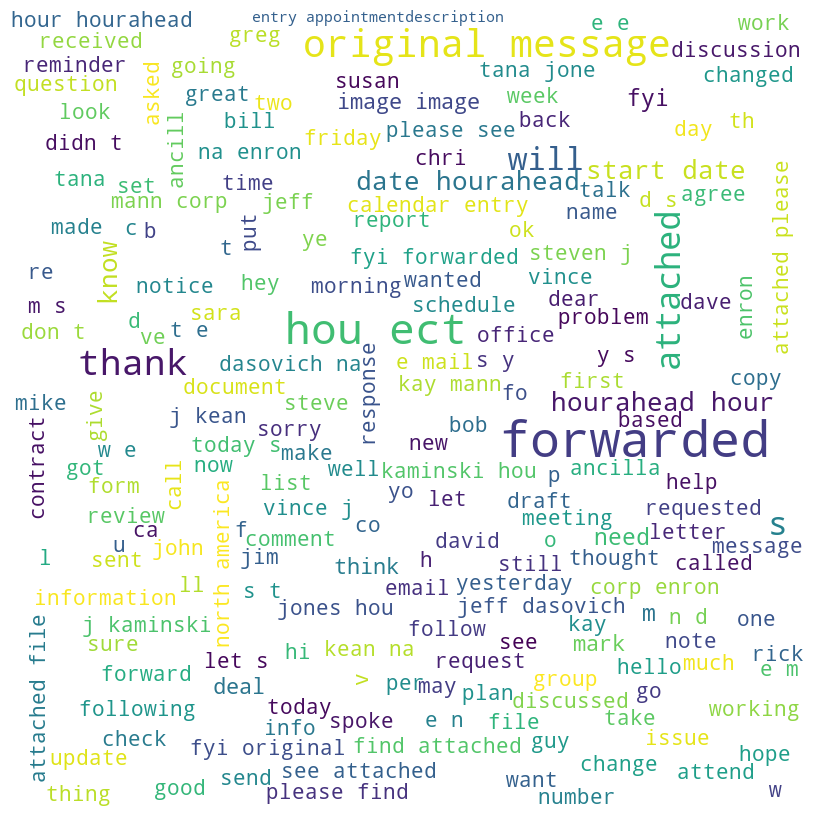

In [15]:
if __name__ == "__main__":
  # Word cloud for content , X-TO, X-From
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS ,
                max_font_size = 50,
                min_font_size = 10).generate(df['content'].to_string())
  # plot the WordCloud image
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

In [16]:
# most frequent words
def word_count(str):
    '''
    Function that get string and counts each word in the string
    '''
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        elif(len(word)>2):
            counts[word] = 1
    return counts

In [17]:
if __name__ == "__main__":
  # moost 100 frequent words in content
  most_frequent_words = Counter(word_count(str(df['content'].to_string()))).most_common(100)
  print('\n'.join(map(str, most_frequent_words)))
  most_frequent_words = None
  del(most_frequent_words)
  gc.collect()


('the', 55709)
('...', 32002)
('you', 27140)
('for', 18368)
('forwarded', 17007)
('this', 16368)
('and', 13695)
('from', 12579)
('have', 12192)
('please', 12119)
('attached', 10966)
('are', 10647)
('that', 9848)
('ect', 9708)
('hou', 9685)
('enron', 8996)
('message', 8887)
('your', 8548)
('original', 7973)
('with', 7878)
('will', 7203)
('thanks', 6452)
('here', 5932)
('fyi', 4770)
('just', 4749)
('has', 4705)
('can', 4506)
('sent', 4350)
('not', 4275)
('all', 4189)
('our', 4036)
('see', 3987)
('know', 3934)
('was', 3934)
('image', 3850)
('date', 3783)
('t...', 3664)
('2...', 3574)
('vince', 3536)
('what', 3455)
('start', 3402)
('mark', 3399)
('hourahead', 3393)
('would', 3364)
('jeff', 3309)
('hour', 3275)
('been', 3158)
('get', 3049)
('good', 2986)
('dear', 2952)
('com', 2921)
('about', 2905)
('out', 2852)
('call', 2842)
('corp', 2830)
('like', 2759)
('today', 2690)
('following', 2660)
('new', 2572)
('a...', 2521)
('let', 2520)
('meeting', 2509)
('need', 2497)
('find', 2483)
('there',

In [18]:
shuffle_df = df.sample(frac=1, random_state=42)

# Define a size for your train set
train_size = int(0.7 * len(df))

# Split your dataset
train_set = shuffle_df[:train_size]
train_set.reset_index(inplace=True, drop=True)

test_set = shuffle_df[train_size:].copy()
test_set.reset_index(inplace=True, drop=True)

In [19]:
import pandas as pd
df = train_set.copy()
df.head()

,file,message,content,body_list
0,tholt-j/discussion_threads/174.,Message-ID: <1554784.1075857488732.JavaMail.ev...,forwarded by jane m tholt hou ect on 11 27 200...,"[forwarded, by, jane, m, tholt, hou, ect, on, ..."
1,kean-s/all_documents/409.,Message-ID: <530637.1075846150302.JavaMail.eva...,kelly raised this concern too the system is se...,"[kelly, raised, this, concern, too, the, syste..."
2,shapiro-r/japan/7.,Message-ID: <14842993.1075844258403.JavaMail.e...,some thoughts 1 we argue against the pjm insta...,"[some, thoughts, 1, we, argue, against, the, p..."
3,lay-k/all_documents/160.,Message-ID: <27787651.1075840204674.JavaMail.e...,mr christman thank you for your invitation for...,"[mr, christman, thank, you, for, your, invitat..."
4,mann-k/all_documents/3727.,Message-ID: <26662615.1075845667335.JavaMail.e...,we are pleased to announce organizational chan...,"[we, are, pleased, to, announce, organizationa..."


In [20]:
corpus = df['body_list'].to_list()

In [ ]:
corpus[0]

126762

bigram_model1 is a nested dictionary structure:

Outer Dictionary:

Keys: First words of bigrams.
Values: Inner dictionaries.
Inner Dictionary:

Keys: Second words of bigrams that follow the first word.
Values: Initial frequency count (0) for each bigram.

bigram_model1 = defaultdict(lambda: defaultdict(lambda: 0)): This line initializes a nested defaultdict. This structure allows us to efficiently store word frequencies. The outer dictionary is keyed by the first word of a bigram, and the inner dictionary is keyed by the second word. The default value for each entry is 0, which represents the initial frequency count.
Count Bigram Frequencies:

for sentence in corpus: Iterates through each sentence in the corpus.

for w1, w2 in bigrams(sentence, pad_right=True, pad_left=True): For each sentence, generates bigrams. The pad_right and pad_left arguments ensure that the first and last words of each sentence are also considered as part of bigrams.
bigram_model1[(w1)][w2] += 1: Increments the frequency count for the bigram (w1, w2).
Calculate Probabilities:

for w1 in bigram_model1: Iterates through each word in the outer dictionary.
total_count = float(sum(bigram_model1[w1].values())): Calculates the total frequency of all bigrams starting with the word w1.
for w2 in bigram_model1[w1]: Iterates through each word w2 that follows w1 in a bigram.
bigram_model1[w1][w2] /= total_count: Divides the frequency of the bigram (w1, w2) by the total frequency of bigrams starting with w1 to obtain the conditional probability P(w2|w1).
Return the Model:

return bigram_model1: Returns the trained bigram model, which can be used to predict the next word in a sequence given the previous word.

In [27]:
def build_bigram_model(corpus):
  # Create a placeholder for model
  bigram_model1 = defaultdict(lambda: defaultdict(lambda: 0))

  # Count frequency of co-occurance
  for sentence in corpus:
      for w1, w2 in bigrams(sentence, pad_right=True, pad_left=True):
          bigram_model1[(w1)][w2] += 1

  # Let's transform the counts to probabilities
  for w1 in bigram_model1:
      print(w1)
      break
      total_count = float(sum(bigram_model1[w1].values()))
      for w2 in bigram_model1[w1]:
          bigram_model1[w1][w2] /= total_count

  return bigram_model1

Consider a simple corpus: "The quick brown fox jumps over the lazy dog."

After processing this corpus, the bigram_model1 might look something like this:

bigram_model1 = {
    'the': {'quick': 0.5, 'lazy': 0.5},
    'quick': {'brown': 1.0},
    'brown': {'fox': 1.0},
    'fox': {'jumps': 1.0},
    'jumps': {'over': 1.0},
    'over': {'the': 1.0},
    'lazy': {'dog': 1.0}
}

In [1]:
bigram = build_bigram_model(corpus)

NameError: name 'build_bigram_model' is not defined

In [ ]:
def get_next_word(model, input_string):
    if len(input_string.split()) > 1:
        input_string_ = input_string.split()
        output = dict(model[tuple(input_string_)])
        return "{} {}".format(input_string,
            list({k: v for k, v in sorted(output.items(), key=lambda item: item[1], reverse=True)})[0])
    else:
        input_string = (input_string)
        output = dict(model[input_string])
        return "{} {}".format(input_string,
            list({k: v for k, v in sorted(output.items(), key=lambda item: item[1], reverse=True)})[0])

In [ ]:
get_next_word(bigram, 'how')